# Correlation plots

start by running all the cells down to [here](#read-in-data)

In [21]:
from pathlib import Path
from typing import Optional, Union

import matplotlib as mpl
from matplotlib import patches, pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler
import scipy.stats
import seaborn as sns

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

def rogi_rmse_corr(df):
    rogi = df["ROGI"].values
    errors = df["RMSE"].values
    r, p = scipy.stats.pearsonr(rogi, errors)
    
    return r or 0

def read_data(json_dir: Path):
    dfs = [pd.read_json(p) for p in json_dir.iterdir() if not p.is_dir()]
    df = pd.concat(dfs, ignore_index=True)\
        .rename(
            columns={
                "dataset_and_task": "task",
                "rogi": "ROGI",
                "rmse": "RMSE",
            }
        )\
        .replace("morgan", "fp")\
        .sort_values(["model", "task", "representation"])\
        .reset_index(drop=True)
    
    return df


def process_df(df: pd.DataFrame, include_extra_rand: bool = False):
    df = df[~df.representation.str.contains('_reinit')]
    if not include_extra_rand:
        df = df[df.representation != "random256"]
        df = df[df.representation != "random512"]

    df = df.drop(["thresholds", "cg_sds", "n_clusters"], axis=1).reset_index(drop=True)
    s_corr = df.groupby(["task", "model"]).apply(rogi_rmse_corr).fillna(0).rename("r")
    
    return df, s_corr


MARKERS = ['o', 'X', 's', 'P', 'D', (4, 1, 0), "^", (4, 1, 45), (5, 1, 0), (5, 1, 60), (6, 1, 0)]
REP_LABELS = dict(
    fp="FP",
    vae="VAE",
    gin="GIN",
    chemberta="ChemBERTa",
    chemgpt="ChemGPT",
    random128=r"$\mathrm{rand}^{128}$",
    random256=r"$\mathrm{rand}^{256}$",
    random512=r"$\mathrm{rand}^{512}$"
)

## Plotting functions

In [22]:
def fill_in_boxes(boxes, c: str= "w", ax: Optional[plt.Axes] = None):
    """Fill in the boxes in the given boxplot with the given color"""
    ax = ax or plt.gca()

    for box in boxes:
        patch = patches.PathPatch(box.get_path(), edgecolor="None", facecolor=c, zorder=1)
        ax.add_patch(patch)

def plot_corr_models(s_corr: pd.Series, ax: plt.Axes = None):
    ax = ax or plt.gca()

    datasets = s_corr.index.unique(0).tolist()
    models = s_corr.index.unique(1).tolist()
    model_colors = sns.color_palette('deep', len(models))

    Y = s_corr.values.reshape(len(datasets), len(models))
    JITTER = 0.1

    bp = ax.boxplot(
        Y,
        vert=True,
        labels=models,
        widths=0.5,
        showmeans=True,
        patch_artist=True,
        boxprops=dict(lw=1.5, fc="None"),
        medianprops=dict(c=None, zorder=2),
        meanprops=dict(ms=10, mew=1.5),
        capprops=dict(lw=1.5),
        showfliers=False,
    )
    fill_in_boxes(bp['boxes'], 'w', ax)

    for median, c in zip(bp['medians'], model_colors):
        median.set_color(c)

    for j in range(Y.shape[1]):
        y = Y[:, j]
        x = (j + 1) + np.random.uniform(-JITTER, JITTER, y.shape)

        ax.plot(x, y, MARKERS[j], c=model_colors[j], mew=1.5, ms=7.5)
    # ax.scatter(x, y, 50, DATASET_COLORS, MARKERS[j], edgecolor='k', linewidth=1.5)

    ax.grid(False, axis='x')
    ax.axhline(0, c='darkgrey', ls='-', lw=1.25, zorder=0.9)
    ax.set_ylim(-1.05, 1.05)
    ax.set_xlabel("Model")
    ax.set_ylabel(r"$r$")
    

def plot_corr_task(s_corr: pd.Series, ax: plt.Axes = None):
    ax = ax or plt.gca()

    datasets = s_corr.index.unique(0).tolist()
    models = s_corr.index.unique(1).tolist()
    dataset_colors = sns.color_palette('pastel', len(datasets))

    ax = sns.scatterplot(
        s_corr.reset_index(), y='task', x="r", hue='task', palette=dataset_colors, 
        style="model", markers=MARKERS, style_order=models,
        edgecolor="k", linewidth=1., s=33,
        legend=False, ax=ax
    )

    ax.set_xlim(-1.05, 1.05)
    ax.grid(False, axis='y')
    ax.axvline(0, c='darkgrey', ls='-', lw=1.25, zorder=0.9)
    ax.set_ylabel("Task")
    ax.set_xlabel(r"$r$")
    ax.tick_params(axis='y', labelsize=8)

    legend_elements = [
        Line2D([0], [0], marker=marker, ls='', color='k', mfc='None', mew=1.5, label=model)
        for marker, model in zip(MARKERS, models)
    ]

    ax.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.0),
        facecolor="w",
        fontsize=8,
        ncols=len(models),
        edgecolor="None",
    )


def plot_corr_single(df: pd.DataFrame, model: str, dataset: str, ax = None):
    ax = ax or plt.gca()

    df_temp = df.query(f"model == '{model}' & task == '{dataset}'")
    reprs, xs, ys = df_temp.representation.values, df_temp.ROGI.values, df_temp.RMSE.values

    for r, x, y, m in zip(reprs, xs, ys, MARKERS):
        ax.scatter(x, y, marker=m, edgecolor="k", linewidth=1, label=REP_LABELS.get(r, r))

    res = scipy.stats.linregress(xs, ys)

    print(f"p: {res.pvalue:0.3f}")
    
    x = np.array(xs)
    y = res.slope * x + res.intercept
    ax.plot([x.min(), x.max()], [y.min(), y.max()], '--', color="darkgrey")

    ax.text(0.03, 0.97, rf"$r={res.rvalue:0.2f}$", ha="left", va="top", transform=ax.transAxes)
    ax.tick_params(direction="out", left=True, bottom=True)
    ax.set_xlabel("ROGI")
    ax.set_ylabel("RMSE")

    return ax

## Read in data

run all the cells above first! Then, set `JSON_DIR` to the directory containing the output cross-validation JSON files for all representations. Finally, run the corresponding cell for the desired figure

In [5]:
v1_dir = Path(f"../results/raw/cv/tdc+guac_v1")
v2_dir = Path(f"../results/raw/cv/tdc+guac_v2")

(df_v1, s_corr_v1), (df_v2, s_corr_v2) = [process_df(read_data(d)) for d in (v1_dir, v2_dir)]
df_v1

,representation,task,ROGI,n_valid,model,r2,RMSE,mae
0,chemberta,ARIPIPRAZOLE_SIMILARITY,0.224108,10000,KNN,0.210001,0.117511,0.093841
1,chemgpt,ARIPIPRAZOLE_SIMILARITY,0.215322,10000,KNN,0.244761,0.114906,0.091574
2,descriptor,ARIPIPRAZOLE_SIMILARITY,0.168301,10000,KNN,0.697986,0.072650,0.056787
3,fp,ARIPIPRAZOLE_SIMILARITY,0.033185,10000,KNN,0.580140,0.085665,0.066644
4,gin,ARIPIPRAZOLE_SIMILARITY,0.203405,10000,KNN,0.486784,0.094668,0.074863
...,...,...,...,...,...,...,...,...
590,descriptor,ZALEPLON_MPO,0.292480,10000,SVR,0.519197,0.142044,0.101720
591,fp,ZALEPLON_MPO,0.078294,10000,SVR,0.273291,0.174635,0.134251
592,gin,ZALEPLON_MPO,0.333256,10000,SVR,0.329022,0.167779,0.125600
593,random128,ZALEPLON_MPO,0.247211,10000,SVR,-0.107225,0.215525,0.177649


In [6]:
s_corr_v1.groupby("model").aggregate(["mean", "median"])

,mean,median
model,,
KNN,0.153300,0.120261
MLP,-0.315066,-0.255368
PLS,0.265995,0.287245
RF,0.278425,0.316473
SVR,0.106983,0.111355


In [7]:
s_corr_v2.groupby("model").aggregate(["mean", "median"])

,mean,median
model,,
KNN,0.877349,0.884159
MLP,0.684595,0.757938
PLS,0.715381,0.786496
RF,0.869853,0.882718
SVR,0.736915,0.802877


In [8]:
df_v1.groupby(["model"]).apply(rogi_rmse_corr)

model
KNN    0.800016
MLP    0.674681
PLS    0.835243
RF     0.809324
SVR    0.771309
dtype: float64

In [9]:
df_v2.groupby(["model"]).apply(rogi_rmse_corr)

model
KNN    0.989733
MLP    0.941058
PLS    0.983030
RF     0.985188
SVR    0.957670
dtype: float64

In [10]:
s_corr_v1.idxmax()

('HALF_LIFE_OBACH', 'KNN')

In [11]:
df_v1

,representation,task,ROGI,n_valid,model,r2,RMSE,mae
0,chemberta,ARIPIPRAZOLE_SIMILARITY,0.224108,10000,KNN,0.210001,0.117511,0.093841
1,chemgpt,ARIPIPRAZOLE_SIMILARITY,0.215322,10000,KNN,0.244761,0.114906,0.091574
2,descriptor,ARIPIPRAZOLE_SIMILARITY,0.168301,10000,KNN,0.697986,0.072650,0.056787
3,fp,ARIPIPRAZOLE_SIMILARITY,0.033185,10000,KNN,0.580140,0.085665,0.066644
4,gin,ARIPIPRAZOLE_SIMILARITY,0.203405,10000,KNN,0.486784,0.094668,0.074863
...,...,...,...,...,...,...,...,...
590,descriptor,ZALEPLON_MPO,0.292480,10000,SVR,0.519197,0.142044,0.101720
591,fp,ZALEPLON_MPO,0.078294,10000,SVR,0.273291,0.174635,0.134251
592,gin,ZALEPLON_MPO,0.333256,10000,SVR,0.329022,0.167779,0.125600
593,random128,ZALEPLON_MPO,0.247211,10000,SVR,-0.107225,0.215525,0.177649


## Marginalized correlation distributions

### Correlation across representation for _each_ model

/tmp/ipykernel_2637798/3160351481.py:58: UserWarning: The markers list has more values (11) than needed (5), which may not be intended.
  ax = sns.scatterplot(


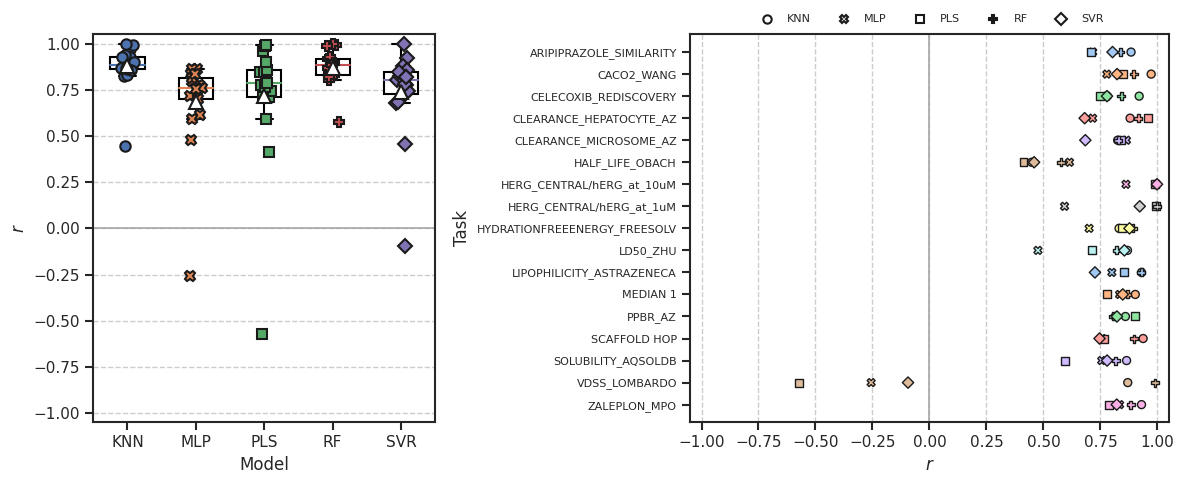

In [24]:
v1 = False

s_corr = s_corr_v1 if v1 else s_corr_v2
version = "v1" if v1 else "v2"

fig, label2ax = plt.subplot_mosaic(
    [['models', 'tasks']], width_ratios=[5, 7], figsize=(12, 5)
)

plot_corr_models(s_corr, label2ax['models'])
plot_corr_task(s_corr, label2ax['tasks'])

fig.tight_layout()
fig.savefig(
    f"../results/figures/correlation/model-task_{version}.pdf", bbox_inches="tight"
)

### Correlation across representation for _best_ model peformance

[0.15687613 0.82394354] [0.18246368 0.75560546]


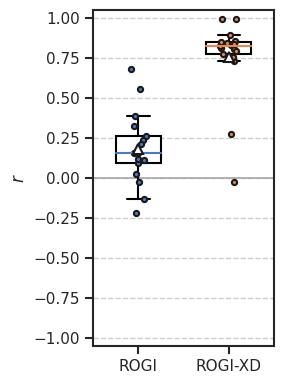

In [27]:
sns.set_palette("muted", 2)

fig, ax = plt.subplots(figsize=(3, 4))
ys = []
for df_ in [df_v1, df_v2]:
    # df_ = df_.groupby(["task", "representation"]).min()
    df_ = df_.loc[df_.groupby(["task", "representation"])['RMSE'].idxmin()]
    ys.append(df_.groupby("task").apply(rogi_rmse_corr).values)
Y = np.array(ys).T

JITTER = 0.1

bp = ax.boxplot(
    Y,
    vert=True,
    labels=["ROGI", "ROGI-XD"],
    widths=0.5,
    showmeans=True,
    patch_artist=True,
    boxprops=dict(lw=1.5, fc="None"),
    medianprops=dict(c=None),
    meanprops=dict(ms=7.5, mew=1.5),
    capprops=dict(lw=1.5),
    showfliers=False,
)
fill_in_boxes(bp['boxes'], 'w', ax)

for j in range(Y.shape[1]):
    y = Y[:, j]
    x = (j + 1) + np.random.uniform(-JITTER, JITTER, y.shape)

    ax.plot(x, y, '.', mew=1.5, ms=7.5)

ax.grid(False, axis='x')
ax.set_ylim(-1.05, 1.05)
ax.axhline(0, c='darkgrey', ls='-', lw=1.25, zorder=0.9)
# ax.set_xlabel("Model")
ax.set_ylabel(r"$r$")

fig.tight_layout()
fig.savefig("../results/figures/correlation/task-best-v1v2.pdf", bbox_inches="tight")
print(np.median(Y, 0), np.mean(Y, 0))

In [155]:
ys = []
for df_ in [df_v1, df_v2]:
    df_ = df_.groupby(["task", "representation"]).min().reset_index()
    res = scipy.stats.linregress(df_["ROGI"].values, df_["RMSE"].values)
    ys.append(res.rvalue)
Y = np.array(ys).T

Y

array([0.79813817, 0.98120288])

In [14]:
df = df_v2
df.loc[df.groupby(["task", "representation"])['RMSE'].idxmin()]

,representation,task,ROGI,n_valid,model,r2,RMSE,mae
476,chemberta,ARIPIPRAZOLE_SIMILARITY,0.158179,10000,SVR,0.528089,0.090815,0.072776
477,chemgpt,ARIPIPRAZOLE_SIMILARITY,0.149287,10000,SVR,0.512825,0.092289,0.072614
478,descriptor,ARIPIPRAZOLE_SIMILARITY,0.106859,10000,SVR,0.780658,0.061909,0.048494
479,fp,ARIPIPRAZOLE_SIMILARITY,0.134765,10000,SVR,0.758516,0.064975,0.051652
480,gin,ARIPIPRAZOLE_SIMILARITY,0.134820,10000,SVR,0.759873,0.064779,0.051463
...,...,...,...,...,...,...,...,...
471,descriptor,ZALEPLON_MPO,0.217616,10000,RF,0.713465,0.109676,0.069755
591,fp,ZALEPLON_MPO,0.262698,10000,SVR,0.273291,0.174635,0.134251
592,gin,ZALEPLON_MPO,0.262321,10000,SVR,0.329021,0.167779,0.125602
355,random128,ZALEPLON_MPO,0.320678,10000,PLS,-0.017773,0.206700,0.160379


In [13]:
df_v2.min()

representation                  chemberta
task              ARIPIPRAZOLE_SIMILARITY
ROGI                             0.041604
n_valid                               642
model                                 KNN
r2                            -178.244902
RMSE                             0.021674
mae                              0.005288
dtype: object

## Correlation plots

In [157]:
s_corr_v1.xs("KNN", level=1)

task
ARIPIPRAZOLE_SIMILARITY         0.360430
CACO2_WANG                      0.235946
CELECOXIB_REDISCOVERY           0.248355
CLEARANCE_HEPATOCYTE_AZ        -0.004606
CLEARANCE_MICROSOME_AZ          0.384459
HALF_LIFE_OBACH                 0.727035
HERG_CENTRAL/hERG_at_10uM       0.116234
HERG_CENTRAL/hERG_at_1uM        0.709724
HYDRATIONFREEENERGY_FREESOLV   -0.213663
LD50_ZHU                        0.047520
LIPOPHILICITY_ASTRAZENECA       0.120261
MEDIAN 1                        0.378728
PPBR_AZ                        -0.418376
SCAFFOLD HOP                   -0.057392
SOLUBILITY_AQSOLDB             -0.242256
VDSS_LOMBARDO                   0.197242
ZALEPLON_MPO                    0.016466
Name: r, dtype: float64

### Single correlation plot



p: 0.427


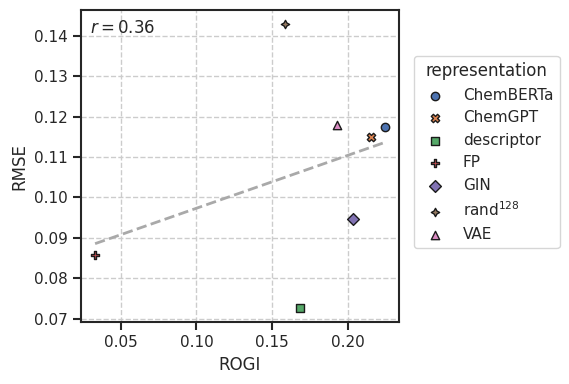

In [161]:
v1 = True

df = df_v1 if v1 else df_v2
version = "v1" if v1 else "v2"

fig, ax = plt.subplots(figsize=(4.25, 4))
plot_corr_single(df, "KNN", "ARIPIPRAZOLE_SIMILARITY", ax)

# fig, axs = plt.subplots(1, 3, figsize=(4*3 + 0.5, 4))
# for model, ax in zip(("SVR", "MLP", "PLS"), axs):
#     plot_corr_single(df, model, "VDSS_LOMBARDO", ax)

fig.legend(title="representation", loc="center left", bbox_to_anchor=(0.975, 0.6))
fig.tight_layout()

In [358]:
fig.savefig(
    f"../results/figures/correlation/zaleplon-svr_{version}.pdf",
    bbox_inches="tight"
)

### ALL plots

In [88]:
for df in [df_v1, df_v2]:
    df.sort_values(["task", "model"], inplace=True)
    df.reset_index(drop=True, inplace=True)

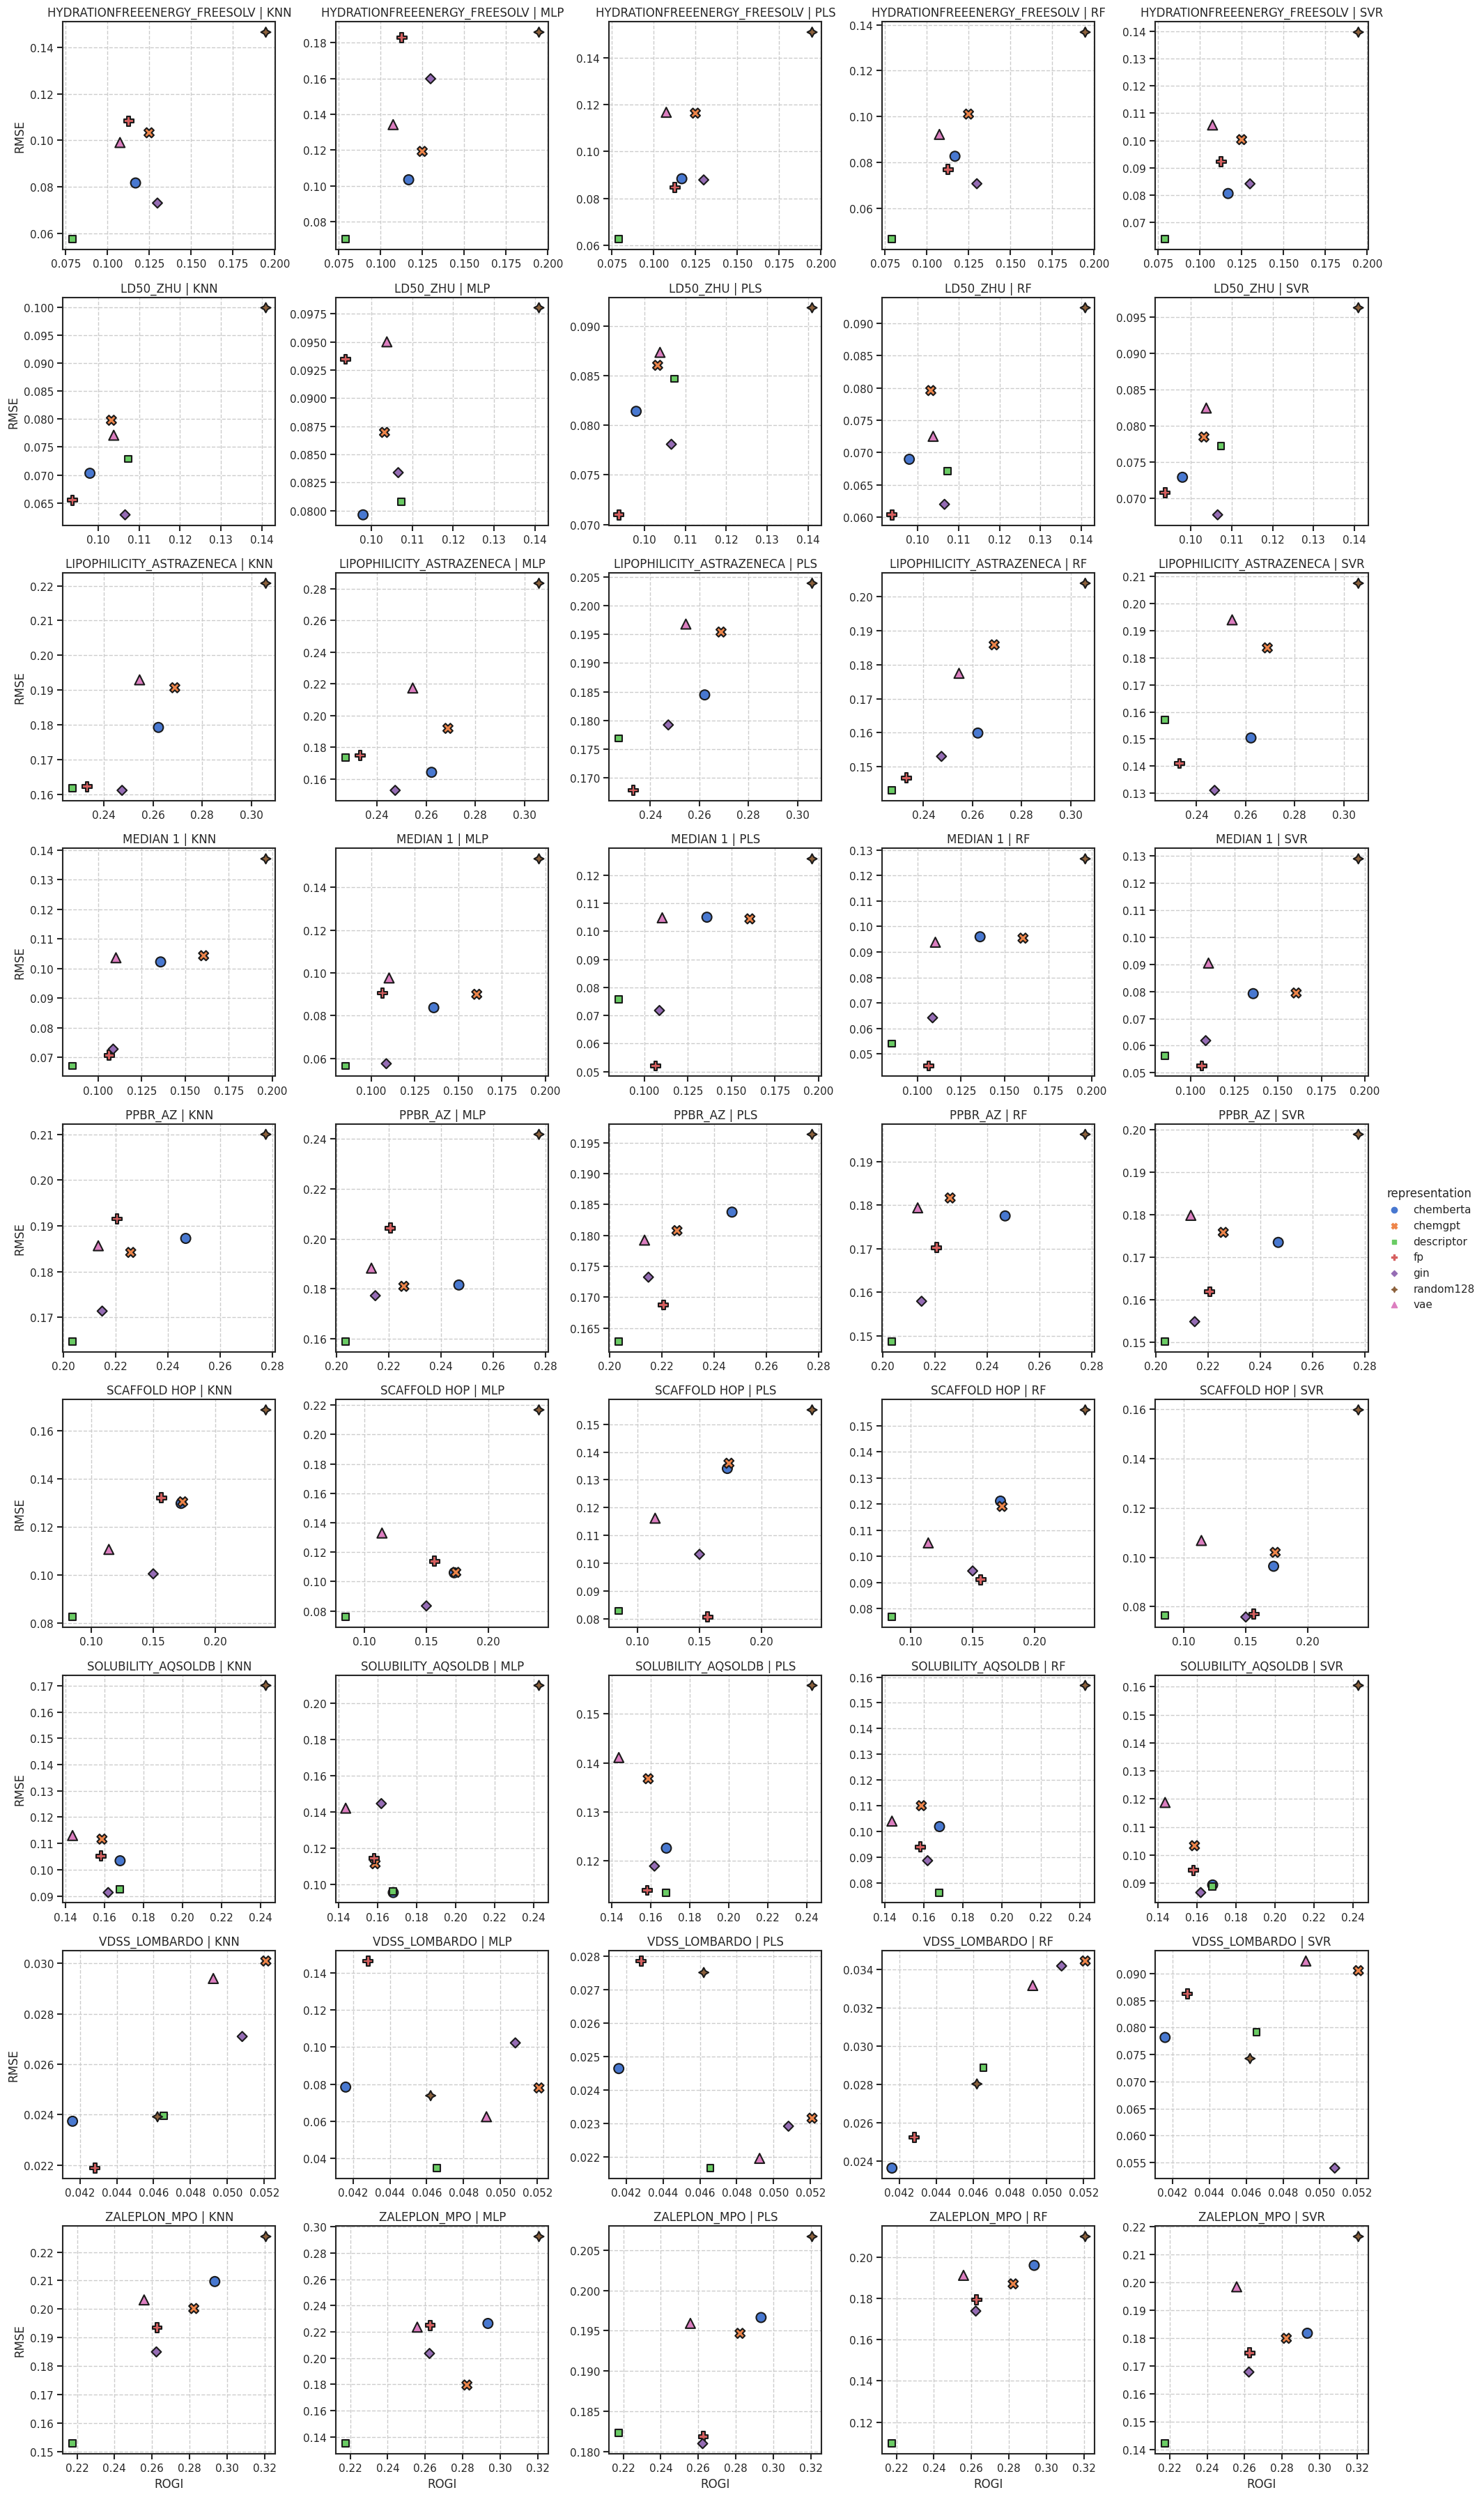

In [89]:
df = df_v2
facetprops = dict(despine=False, sharex=False, sharey=False)

N = len(df) // 35 // 2 * 35
g = sns.relplot(
    df.iloc[N:],
    x="ROGI", y="RMSE", col="model", row="task",
    hue="representation", style="representation", palette="muted",
    height=4, legend="auto", facet_kws=facetprops,
    edgecolor='k', linewidth=1.5, s=100
)

for ax in g.axes.flat:
    ax.grid(True, ls="--")

g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.savefig(f"../results/figures/correlation/all_v2_1-2.pdf", bbox_inches="tight")

# Dataset correlation reproduction

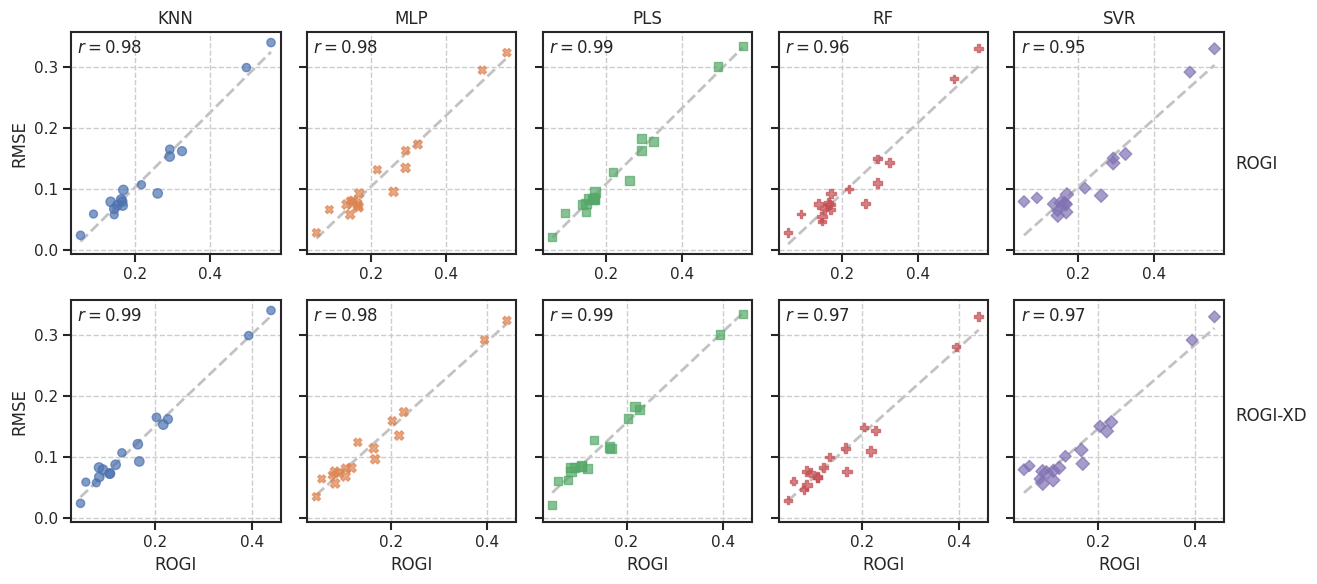

In [10]:
fig, axss = plt.subplots(2, 5, figsize=(5 * 2.5, 2 * 3), sharey=True)

for i, (axs, df) in enumerate(zip(axss, [df_v1, df_v2])):
    models = df.model.unique()
    model_colors = sns.color_palette('deep', len(models))

    for j, (ax, model) in enumerate(zip(axs, models)):
        df_ = df.query(f"representation == 'descriptor' and model == '{model}'")
        xs, ys, Y = df_['ROGI'], df_['RMSE'], 5 * np.log(df_['n_valid'])

        ax.scatter(xs, ys, Y, color=model_colors[j], marker=MARKERS[j], alpha=0.7)
        res = scipy.stats.linregress(xs, ys)
        x = np.array(xs)
        y = res.slope * x + res.intercept
        ax.plot([x.min(), x.max()], [y.min(), y.max()], '--', color="darkgrey", zorder=-1, alpha=0.7)
        ax.text(0.03, 0.97, rf"$r={res.rvalue:0.2f}$", ha="left", va="top", transform=ax.transAxes)
        
        if i == 0:
            ax.set_title(model)

# for ax, label in zip([axss[0][-1], axss[1][-1]], ("ROGI", "ROGI-CD")):
#     # ax = ax.twinx()
#     # ax.set_yticks([])
#     ax.text(label, rotation='horizontal')
#     # ax.grid(False)


[ax.set_ylabel("RMSE") for ax in [axss[0][0], axss[1][0]]]
[ax.set_xlabel("ROGI") for ax in axss[1]]

fig.text(0.995, axss[0][0].get_position().intervaly.mean(), "ROGI")
fig.text(0.995, axss[1][0].get_position().intervaly.mean(), "ROGI-XD")

fig.tight_layout()
fig.savefig("../results/figures/correlation/tasks-both.pdf", bbox_inches="tight")

---
## GRAVEYARD
---

In [ ]:
TABLE_FILE.parent.mkdir(exist_ok=True, parents=True)

Styler(
    df.groupby(["dataset_and_task", 'range', "model"])\
        .mean()\
        .rename_axis(index={"dataset_and_task": "task"})\
        .rename(index=lambda s: s.lower().capitalize(), level=0),
    precision=3
)\
.format_index(escape="latex", axis=0, precision=3)\
.format_index(escape="latex", axis=1)\
.hide(axis=0, level=-1)\
.hide(["rogi", "r2", "rmse", "mae"], axis=1)\
.to_latex(TABLE_FILE, hrules=True, sparse_columns=True)

Optionally, save the results to a CSV

In [ ]:
df.reset_index().to_csv(TABLE_FILE.with_suffix(".csv"), index=False, float_format="%0.3f")

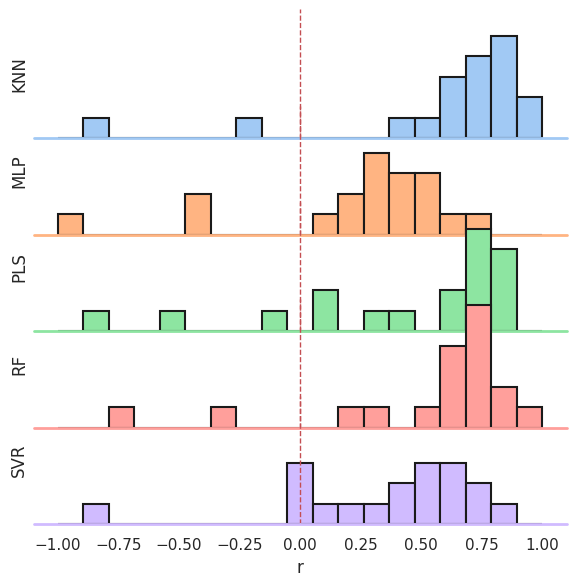

In [ ]:
g = sns.FacetGrid(
    df_grouped.reset_index(), row='model', hue='model', aspect=5, height=1.25, palette=MODEL_COLORS,
    sharey=True, sharex=True
)

g.map(
    sns.histplot, 'r',
    clip_on=False, alpha=1, linewidth=1.5, bins=np.linspace(-1, 1, 20), edgecolor='k'
)

g.map(plt.axvline, x=0, lw=1, ls="--", c="r", clip_on=False)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(MODELS[i])

g.fig.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g

/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


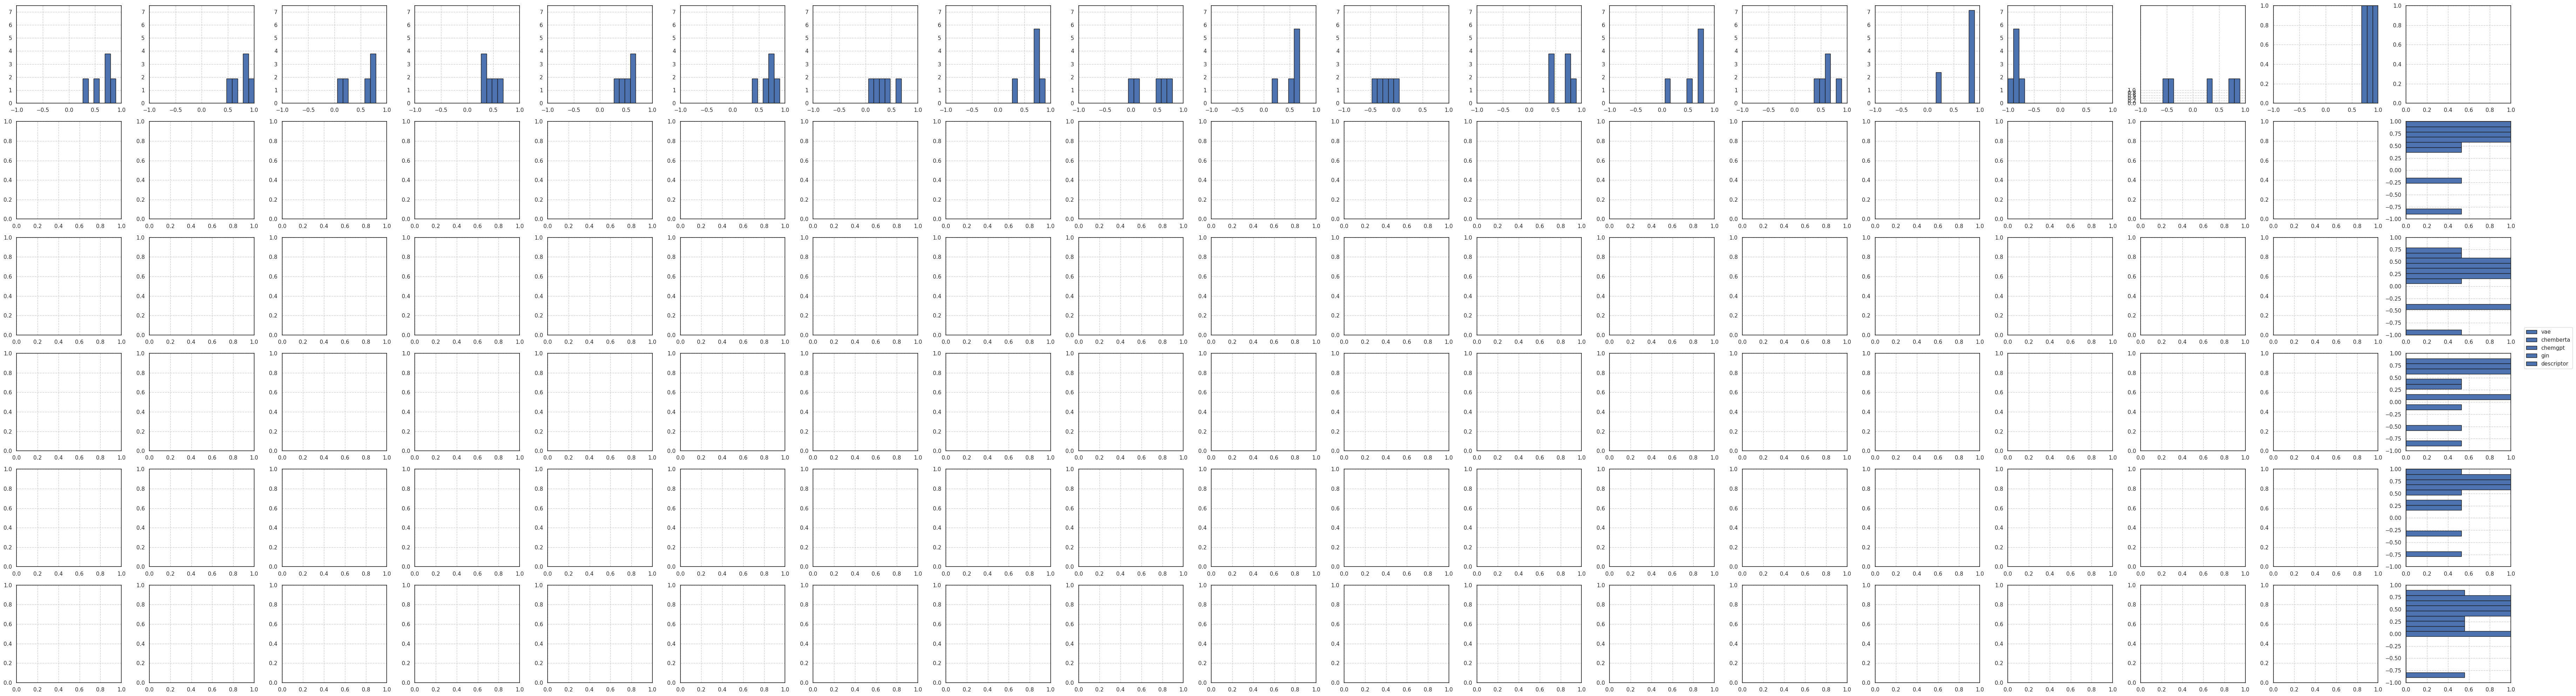

In [ ]:
df = df.sort_values(["model", "task", "features"])

MODELS = df["model"].unique()
TASKS = df["task"].unique()
colors = sns.color_palette("deep", 5)
markers = ['o', 'X', 'P', 's', 'D']

nrows = len(MODELS)
ncols = len(TASKS)
fig, axs = plt.subplots(
    nrows, ncols, figsize=(4 * ncols, 4 * nrows), sharex=False, sharey=False
)

def corr_plot(ax: plt.Axes, xs, ys, markers, colors, labels):
    BUFFER = 0.03

    for x, y, m, c, l in zip(xs, ys, markers, colors, labels):
        ax.scatter(x, y, 50, marker=m, color=c, edgecolors='k', label=l)

    r, _ = scipy.stats.pearsonr(xs, ys)
    s = rf"$r = {r:0.3f}$"
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='none')
    ax.text(
        0 + BUFFER, 1 - BUFFER, s,
        ha="left", va="top", fontsize=10, transform=ax.transAxes, bbox=bbox
    )
    
    ax.grid(True)


for i, model in enumerate(MODELS):   
    for j, dset in enumerate(TASKS):

        s = df.query(f"model == '{model}' and dataset == '{dset}'")
        corr_plot(
            axs[i+1, j], s["ROGI"].values, s["RMSE"].values, markers, colors, s.features
        )

        axs[i, j].set_title(f"{model} | {dset}")

fig.legend(s.features, loc='center left', bbox_to_anchor=(1.0, 0.5))
# fig.subplots_adjust(wspace=1)
# fig.supxlabel(r"$N_{\mathrm{clusters}} / N$", fontsize=16)
# fig.supylabel(r"$2(\sigma_0 - \sigma_t)$", x=0.01, fontsize=16)

fig.tight_layout()